### **Experiment Log:**

|Version |Models Used |CV Score |LB Score| Changes Made
| --- | --- | --- | --- | --- |
|v1 |Lasso, ElasticNet | 0.8361 | 0.843 | Baseline
|v2 |Lasso, ElasticNet | 0.8361 | 0.843 | TF-IDF
|v3 |Lasso, ElasticNet | 0.8361 | NA | TF-IDF (-) <br> Glove (+)
|v4 |Lasso, ElasticNet <br> LightGBM, XGBoost | 0.7485 | 0.654 | Glove
|v5 |Conv1D, Bidirectional LSTM | 0.6344 | 0.603 | Glove
|v6 |Conv1D, Bidirectional LSTM | 0.6436 | NA | Glove + FastText <br> Model architecture modified
|v7 |Conv1D, Bidirectional LSTM | 0.6443 | 0.583 | Model architecture modified
|v8 |Conv1D, Bidirectional LSTM | 0.6652 | 0.629 | Bert Embeddings
|v9 |Conv1D, Bidirectional LSTM | 0.6416 | 0.596 | Bert Embeddings (-) <br> Glove + FastText (+)
|v10 |Transformer block with attention | 0.6466 | NA | Glove + FastText
|v11 |Transformer block with attention | 0.6497 | 0.596 | Changed TF initialization process
|v12 |Conv1D, Bidirectional LSTM | 0.6482 | NA | Reverting to v7 model architecture <br> (with TF initialization changes)
|v13 |Conv1D, Bidirectional LSTM | 0.6496 | 0.575 | Bug fix in predictions
|v14 |Conv1D, Bidirectional LSTM | 0.3216 | NA | Pretrained DistilBert Embeddings <br> (with same model backbone)
|v15 |Conv1D, Bidirectional LSTM | 0.3283 | 0.561 | Pretrained DistilBert Embeddings <br> (training for single seed)
|v16 |Conv1D, Bidirectional LSTM | 0.6712 | 0.593 | Glove + FastText (Common Crawl)
|v17 |Bidirectional LSTM & GRU <br> (with attention) | 0.6312 | 0.592 | Model architecture modified
|v18 |Bidirectional LSTM & GRU <br> (with attention) | 0.6313 | 0.583 | Glove + FastText (Wiki-News)
|v19 |Bidirectional LSTM & GRU <br> (with attention) | 0.6413 | 0.597 | Fix for OOV tokens
|v20 |Conv1D, Bidirectional LSTM | 0.6563 | 0.615 | Switched to v13 model architecture
|v21 |Conv1D, Bidirectional LSTM | 0.6372 | NA | Glove + FastText + Word2Vec <br> (Weighted embeddings) <br> Model architecture modified
|v22 |Conv1D, Bidirectional LSTM | 0.6367 | 0.589 | Glove + FastText <br> (Weighted embeddings) <br> Model architecture modified
|v23 |Conv1D, Bidirectional LSTM | 0.6568 | 0.593 | Glove + FastText <br> (Weighted embeddings) <br> v13 Model architecture
|v24 |Conv1D, Bidirectional LSTM | TBD | TBD | Pretrained DistilRoberta Embeddings

## Import libraries

In [1]:
import gc
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import re
import nltk
import spacy
import string
from textblob import TextBlob
from collections import Counter
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.initializers import LecunNormal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Attention, Dropout
from tensorflow.keras.layers import Dense, Input, Conv1D
from tensorflow_addons.layers import WeightNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Flatten, Bidirectional
from tensorflow.keras.layers import Activation, SpatialDropout1D
from tensorflow.keras.layers import GlobalMaxPool1D, Concatenate

from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig

## Load source datasets

In [2]:
train_df = pd.read_csv("../input/commonlitreadabilityprize/train.csv")
train_df.drop(['url_legal','license','standard_error'], inplace=True, axis=1)
train_df.set_index("id", inplace=True)
print(f"train_df: {train_df.shape}\n")
train_df.head()

train_df: (2834, 2)



,excerpt,target
id,,
c12129c31,When the young people returned to the ballroom...,-0.340259
85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",-0.315372
b69ac6792,"As Roger had predicted, the snow departed as q...",-0.580118
dd1000b26,And outside before the palace a great garden w...,-1.054013
37c1b32fb,Once upon a time there were Three Bears who li...,0.247197


In [3]:
test_df = pd.read_csv("../input/commonlitreadabilityprize/test.csv")
test_df.drop(['url_legal','license'], inplace=True, axis=1)
test_df.set_index("id", inplace=True)
print(f"test_df: {test_df.shape}\n")
test_df.head()

test_df: (7, 1)



,excerpt
id,
c0f722661,My hope lay in Jack's promise that he would ke...
f0953f0a5,Dotty continued to go to Mrs. Gray's every nig...
0df072751,It was a bright and cheerful scene that greete...
04caf4e0c,Cell division is the process by which a parent...
0e63f8bea,Debugging is the process of finding and resolv...


## Extract target label

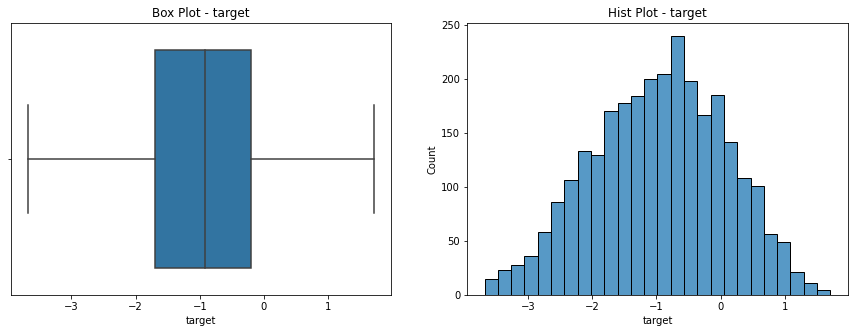

In [4]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x='target', data=train_df, ax=ax[0])
sns.histplot(x='target', data=train_df, ax=ax[1])
ax[0].title.set_text('Box Plot - target')
ax[1].title.set_text('Hist Plot - target')

In [5]:
Ytrain = train_df['target'].values
Ytrain_strat = pd.qcut(train_df['target'].values, q=5, labels=range(0,5))
train_df.drop(['target'], inplace=True, axis=1)
print("Ytrain: {}".format(Ytrain.shape))

Ytrain: (2834,)


## Feature Engineering

In [6]:
def contraction_count(sent):
    count = 0
    count += re.subn(r"won\'t", '', sent)[1]
    count += re.subn(r"can\'t", '', sent)[1]
    count += re.subn(r"n\'t", '', sent)[1]
    count += re.subn(r"\'re", '', sent)[1]
    count += re.subn(r"\'s", '', sent)[1]
    count += re.subn(r"\'d", '', sent)[1]
    count += re.subn(r"\'ll", '', sent)[1]
    count += re.subn(r"\'t", '', sent)[1]
    count += re.subn(r"\'ve", '', sent)[1]
    count += re.subn(r"\'m", '', sent)[1]
    return count

In [7]:
def pos_count(sent):
    nn_count = 0   #Noun
    pr_count = 0   #Pronoun
    vb_count = 0   #Verb
    jj_count = 0   #Adjective
    uh_count = 0   #Interjection
    cd_count = 0   #Numerics
    
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)

    for token in sent:
        if token[1] in ['NN','NNP','NNS']:
            nn_count += 1

        if token[1] in ['PRP','PRP$']:
            pr_count += 1

        if token[1] in ['VB','VBD','VBG','VBN','VBP','VBZ']:
            vb_count += 1

        if token[1] in ['JJ','JJR','JJS']:
            jj_count += 1

        if token[1] in ['UH']:
            uh_count += 1

        if token[1] in ['CD']:
            cd_count += 1
    
    return pd.Series([nn_count, pr_count, vb_count, jj_count, uh_count, cd_count])

In [8]:
def dialog_parser(text):
    
    tokenized = nltk.word_tokenize(text)
    
    # let's set up some lists to hold our pieces of narrative and dialog
    parsed_dialog = []
    parsed_narrative = []
    
    # and this list will be a bucket for the text we're currently exploring
    current = []

    # now let's set up values that will help us loop through the text
    length = len(tokenized)
    found_q = False
    counter = 0
    quote_open, quote_close = '``', "''"

    # now we'll start our loop saying that as long as our sentence is...
    while counter < length:
        word = tokenized[counter]

        # until we find a quotation mark, we're working with narrative
        if quote_open not in word and quote_close not in word:
            current.append(word)

        # here's what we do when we find a closed quote
        else:
            # we append the narrative we've collected & clear our our
            # current variable
            parsed_narrative.append(current)
            current = []
            
            # now current is ready to hold dialog and we're working on
            # a piece of dialog
            current.append(word)
            found_q = True

            # while we're in the quote, we're going to increment the counter
            # and append to current in this while loop
            while found_q and counter < length-1:
                counter += 1
                if quote_close not in tokenized[counter]:
                    current.append(tokenized[counter])
                else:
                    # if we find a closing quote, we add our dialog to the
                    # appropriate list, clear current and flip our found_q
                    # variable to False
                    current.append(tokenized[counter])
                    parsed_dialog.append(current)
                    current = []
                    found_q = False

        # increment the counter to move us through the text
        counter += 1
    
    if len(parsed_narrative) == 0:
        parsed_narrative.append(current)
    
    mean_dialog_word_len = 0
    
    if len(parsed_dialog) > 0:
        for text in parsed_dialog:
            join_text = " ".join(text)
            join_text = join_text.replace('"','')
            join_text = join_text.replace("''","")
            mean_dialog_word_len += len(join_text.split())
        
        mean_dialog_word_len /= float(len(parsed_dialog))
    
    mean_narrative_word_len = 0
    
    if len(parsed_narrative) > 0:
        for text in parsed_narrative:
            join_text = " ".join(text)
            join_text = join_text.replace('"','')
            join_text = join_text.replace("''","")
            mean_narrative_word_len += len(join_text.split())
        
        mean_narrative_word_len /= float(len(parsed_narrative))

    return len(parsed_dialog), len(parsed_narrative), mean_dialog_word_len, mean_narrative_word_len

In [9]:
def decontraction(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [10]:
def remove_punctuations(text):
    for punctuation in list(string.punctuation):
        text = text.replace(punctuation, '')
    return text

In [11]:
def lemmatize_words(text):
    lemmatizer = WordNetLemmatizer()
    wordnet_map = {
        "N": wordnet.NOUN, 
        "V": wordnet.VERB, 
        "J": wordnet.ADJ, 
        "R": wordnet.ADV
    }
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [12]:
combined_df = train_df.append(test_df, sort=False, ignore_index=False)

del train_df
del test_df
gc.collect()

combined_df.head()

,excerpt
id,
c12129c31,When the young people returned to the ballroom...
85aa80a4c,"All through dinner time, Mrs. Fayre was somewh..."
b69ac6792,"As Roger had predicted, the snow departed as q..."
dd1000b26,And outside before the palace a great garden w...
37c1b32fb,Once upon a time there were Three Bears who li...


In [13]:
cnt = Counter()
for text in combined_df["excerpt"].values:
    for word in text.split():
        cnt[word] += 1


freq_words = []
for (w, wc) in tqdm(cnt.most_common()):
    if wc > 3500:
        freq_words.append(w)

len(freq_words)

100%|██████████| 54474/54474 [00:00<00:00, 1468912.44it/s]


11

In [14]:
combined_df["excerpt_num_words"] = combined_df["excerpt"].apply(lambda x: len(str(x).split()))
combined_df["excerpt_num_unique_words"] = combined_df["excerpt"].apply(lambda x: len(set(str(x).split())))
combined_df["excerpt_num_chars"] = combined_df["excerpt"].apply(lambda x: len(str(x)))
combined_df["excerpt_num_stopwords"] = combined_df["excerpt"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords.words('english')]))
combined_df["excerpt_num_punctuations"] =combined_df['excerpt'].apply(lambda x: len([c for c in str(x) if c in list(string.punctuation)]))
combined_df["excerpt_num_words_upper"] = combined_df["excerpt"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
combined_df["excerpt_num_words_title"] = combined_df["excerpt"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
combined_df["excerpt_mean_word_len"] = combined_df["excerpt"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
combined_df["excerpt_num_paragraphs"] = combined_df["excerpt"].apply(lambda x: len(x.split('\n')))
combined_df["excerpt_num_sentences"] = combined_df["excerpt"].apply(lambda x: len(str(x).split('.')))
combined_df["excerpt_num_contractions"] = combined_df["excerpt"].apply(contraction_count)
combined_df["excerpt_freq_words"] = combined_df["excerpt"].apply(lambda x: len([w for w in str(x).split() if w in freq_words]))
combined_df["excerpt_num_dialog"] = combined_df["excerpt"].apply(lambda x: dialog_parser(x)[0])
combined_df["excerpt_num_narrative"] = combined_df["excerpt"].apply(lambda x: dialog_parser(x)[1])
combined_df["excerpt_dialog_mean_word_len"] = combined_df["excerpt"].apply(lambda x: dialog_parser(x)[2])
combined_df["excerpt_narrative_mean_word_len"] = combined_df["excerpt"].apply(lambda x: dialog_parser(x)[3])
combined_df['excerpt_polarity'] = combined_df['excerpt'].apply(lambda x: TextBlob(x).sentiment[0])
combined_df['excerpt_subjectivity'] = combined_df['excerpt'].apply(lambda x: TextBlob(x).sentiment[1])
combined_df[['nn_count','pr_count','vb_count','jj_count','uh_count','cd_count']] = combined_df['excerpt'].apply(pos_count)
combined_df.head()

,excerpt,excerpt_num_words,excerpt_num_unique_words,excerpt_num_chars,excerpt_num_stopwords,excerpt_num_punctuations,excerpt_num_words_upper,excerpt_num_words_title,excerpt_mean_word_len,excerpt_num_paragraphs,...,excerpt_dialog_mean_word_len,excerpt_narrative_mean_word_len,excerpt_polarity,excerpt_subjectivity,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count
id,,,,,,,,,,,,,,,,,,,,,
c12129c31,When the young people returned to the ballroom...,179,114,992,88,27,0,16,4.547486,6,...,0.000000,204.0,0.134848,0.525758,48,4,34,13,0,4
85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",169,127,937,73,56,6,28,4.550296,6,...,18.833333,14.5,0.133999,0.566643,32,29,38,13,1,0
b69ac6792,"As Roger had predicted, the snow departed as q...",166,128,908,75,47,2,29,4.475904,5,...,23.200000,17.8,0.082672,0.611640,42,21,33,9,0,1
dd1000b26,And outside before the palace a great garden w...,164,118,909,70,33,0,8,4.548780,2,...,0.000000,194.0,0.333869,0.636667,52,12,19,16,0,3
37c1b32fb,Once upon a time there were Three Bears who li...,147,51,723,75,32,0,42,3.925170,1,...,0.000000,175.0,0.198611,0.567593,51,6,10,13,0,3


<AxesSubplot:>

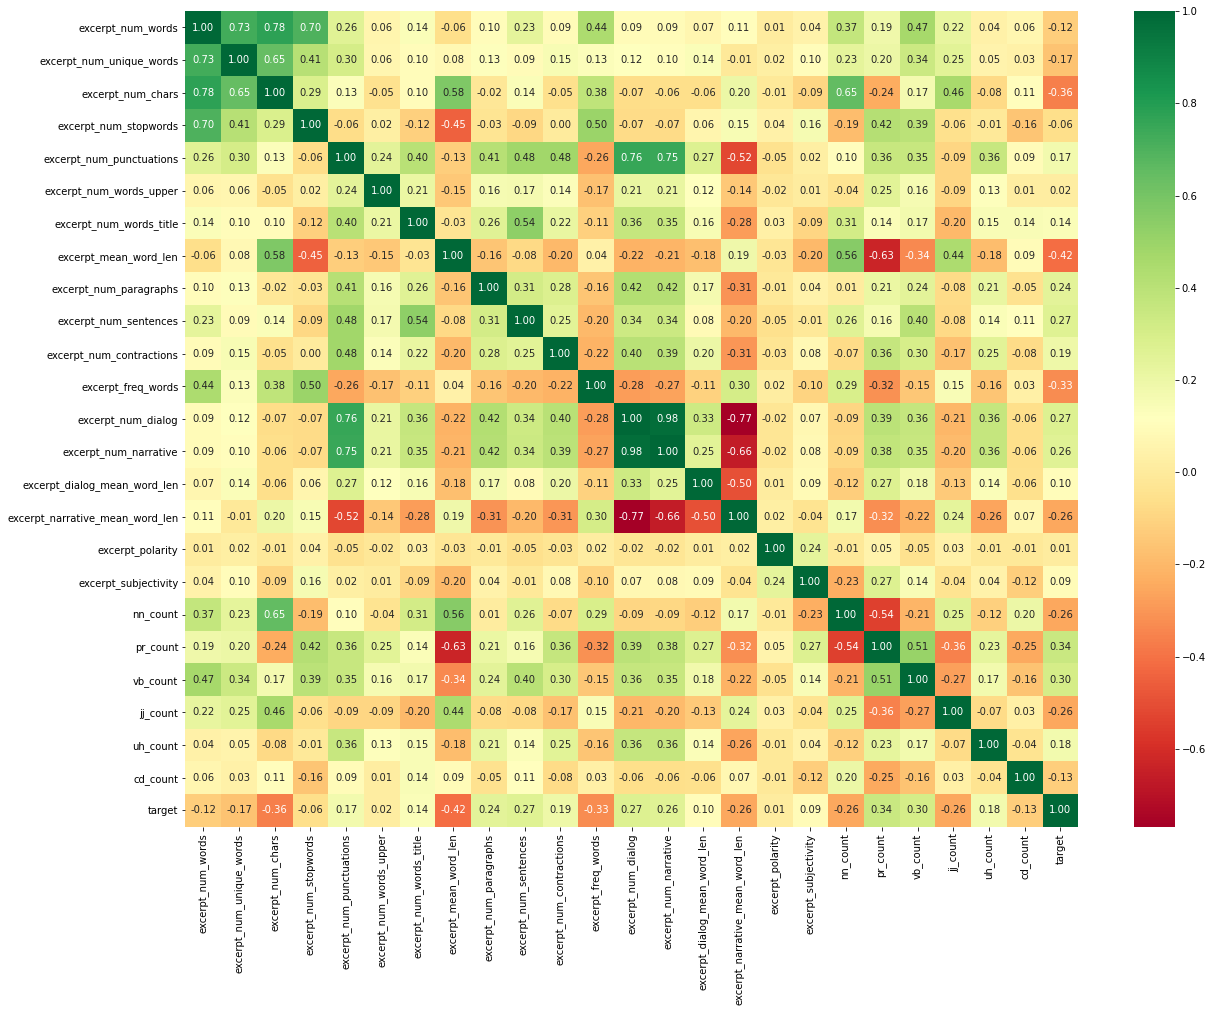

In [15]:
df = combined_df[:Ytrain.shape[0]].copy()
df['target'] = Ytrain
plt.figure(figsize=(20, 15))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap="RdYlGn")

In [16]:
# Convert to lower case
combined_df['excerpt'] = combined_df['excerpt'].apply(lambda x: str(x).lower().replace('\\', '').replace('_', ' '))

# Remove double spaces
combined_df['excerpt'] = combined_df['excerpt'].apply(lambda x: re.sub('\s+',  ' ', x))

# Replace contractions ("don't" with "do not" and "we've" with "we have")
combined_df['excerpt'] = combined_df['excerpt'].apply(lambda x: decontraction(x))

# Remove punctuations
combined_df['excerpt'] = combined_df['excerpt'].apply(remove_punctuations)

# Lemmatize words
combined_df['excerpt'] = combined_df['excerpt'].apply(lambda text: lemmatize_words(text))

combined_df.head()

,excerpt,excerpt_num_words,excerpt_num_unique_words,excerpt_num_chars,excerpt_num_stopwords,excerpt_num_punctuations,excerpt_num_words_upper,excerpt_num_words_title,excerpt_mean_word_len,excerpt_num_paragraphs,...,excerpt_dialog_mean_word_len,excerpt_narrative_mean_word_len,excerpt_polarity,excerpt_subjectivity,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count
id,,,,,,,,,,,,,,,,,,,,,
c12129c31,when the young people return to the ballroom i...,179,114,992,88,27,0,16,4.547486,6,...,0.000000,204.0,0.134848,0.525758,48,4,34,13,0,4
85aa80a4c,all through dinner time mr fayre be somewhat s...,169,127,937,73,56,6,28,4.550296,6,...,18.833333,14.5,0.133999,0.566643,32,29,38,13,1,0
b69ac6792,a roger have predict the snow depart as quickl...,166,128,908,75,47,2,29,4.475904,5,...,23.200000,17.8,0.082672,0.611640,42,21,33,9,0,1
dd1000b26,and outside before the palace a great garden b...,164,118,909,70,33,0,8,4.548780,2,...,0.000000,194.0,0.333869,0.636667,52,12,19,16,0,3
37c1b32fb,once upon a time there be three bear who live ...,147,51,723,75,32,0,42,3.925170,1,...,0.000000,175.0,0.198611,0.567593,51,6,10,13,0,3


In [17]:
# Extract excerpts
train_list = combined_df[:Ytrain.shape[0]]['excerpt'].tolist()
test_list = combined_df[Ytrain.shape[0]:]['excerpt'].tolist()
MAX_LEN = combined_df['excerpt_num_words'].max() + 11
print(f"Train excerpts: {len(train_list)} \nTest excerpts: {len(test_list)} \nMAX_LEN: {MAX_LEN}")

Train excerpts: 2834 
Test excerpts: 7 
MAX_LEN: 216


In [18]:
selected_features = ['excerpt_num_words','excerpt_num_unique_words','excerpt_num_chars',
                     'excerpt_num_punctuations','excerpt_num_words_title','excerpt_mean_word_len',
                     'excerpt_num_paragraphs','excerpt_num_contractions','excerpt_freq_words',
                     'excerpt_num_dialog','excerpt_narrative_mean_word_len','nn_count','pr_count',
                     'vb_count','jj_count','uh_count','cd_count']

combined_df = combined_df[selected_features].copy()

In [19]:
Xtrain = combined_df[:Ytrain.shape[0]].copy()
Xtest = combined_df[Ytrain.shape[0]:].copy()
print(f"Xtrain: {Xtrain.shape} \nXtest: {Xtest.shape}")

del combined_df
gc.collect()

Xtrain: (2834, 17) 
Xtest: (7, 17)


60

## Generate word token and attention mask

In [20]:
DISTILROBERTA_BASE = "../input/huggingface-roberta-variants/distilroberta-base/distilroberta-base"

In [21]:
def sent_encode(texts, tokenizer):
    input_ids = []
    attention_mask = []

    for text in tqdm(texts):
        tokens = tokenizer.encode_plus(text, max_length=MAX_LEN, truncation=True, 
                                       padding='max_length', add_special_tokens=True, 
                                       return_attention_mask=True, return_token_type_ids=False, 
                                       return_tensors='tf')
        
        input_ids.append(tokens['input_ids'])
        attention_mask.append(tokens['attention_mask'])

    return np.array(input_ids), np.array(attention_mask)

In [22]:
tokenizer = RobertaTokenizer.from_pretrained(DISTILROBERTA_BASE)

In [23]:
Xtrain_id, Xtrain_mask = sent_encode(train_list, tokenizer)

Xtrain_id = Xtrain_id.reshape((Xtrain_id.shape[0], Xtrain_id.shape[2]))
Xtrain_mask = Xtrain_mask.reshape((Xtrain_mask.shape[0], Xtrain_mask.shape[2]))
    
print(f"Input-ids: {Xtrain_id.shape} \nAttention Mask: {Xtrain_mask.shape}")

100%|██████████| 2834/2834 [00:05<00:00, 479.43it/s]


Input-ids: (2834, 216) 
Attention Mask: (2834, 216)


In [24]:
Xtest_id, Xtest_mask = sent_encode(test_list, tokenizer)

Xtest_id = Xtest_id.reshape((Xtest_id.shape[0], Xtest_id.shape[2]))
Xtest_mask = Xtest_mask.reshape((Xtest_mask.shape[0], Xtest_mask.shape[2]))
    
print(f"Input-ids: {Xtest_id.shape} \nAttention Mask: {Xtest_mask.shape}")

100%|██████████| 7/7 [00:00<00:00, 642.27it/s]

Input-ids: (7, 216) 
Attention Mask: (7, 216)


## Base Model

* **DistilRoberta Embeddings**
* **Conv1D + Bidirectional LSTM**

In [25]:
def rmse_loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    return tf.math.sqrt(tf.math.reduce_mean((y_true - y_pred)**2))

In [26]:
def distilroberta_model(transformer_model):
    
    input_id = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

    embed = transformer_model(input_id, attention_mask=attention_mask)[0]    
    embed = LayerNormalization(name='Embedding')(embed)
    
    x = WeightNormalization(
            Conv1D(filters=384, kernel_size=5, 
                   strides=2, padding='same', 
                   kernel_regularizer=l2(0.0001),
                   kernel_initializer='he_uniform'))(embed)
    x = LayerNormalization()(x)
    x = Activation('relu')(x)
    x = SpatialDropout1D(rate=0.25)(x)
    
    x = WeightNormalization(
            Conv1D(filters=192, kernel_size=5, 
                   strides=2, padding='same', 
                   kernel_regularizer=l2(0.0001),
                   kernel_initializer='he_uniform'))(x)
    x = LayerNormalization()(x)
    x = Activation('relu')(x)
    x = SpatialDropout1D(rate=0.25)(x)
    
    x = Flatten()(x)
    x = Dropout(rate=0.5)(x)
    
    x = Dense(units=1, kernel_initializer='lecun_normal')(x)

    model = Model(inputs=[input_id, attention_mask], outputs=x, 
                  name='Pretrained_DistilRoberta_Model')
    return model

In [27]:
def build_model(distilroberta_embeddings, stat_input, seed=0):
    
    x1 = Bidirectional(LSTM(units=96, activation='tanh',
                            return_sequences=True, dropout=0.25,
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer=LecunNormal(seed=seed)))(distilroberta_embeddings)
    x1 = LayerNormalization(epsilon=1e-5)(x1)
    
    x2 = Conv1D(filters=96, kernel_size=5, 
                strides=2, padding='same', 
                kernel_regularizer=l2(0.0003),
                kernel_initializer=LecunNormal(seed=seed))(x1)
    x2 = Activation('relu')(x2)
    x2 = LayerNormalization(epsilon=1e-5)(x2)
    x2 = SpatialDropout1D(rate=0.25)(x2)
    
    x2 = Conv1D(filters=192, kernel_size=3, 
                strides=2, padding='same', 
                kernel_regularizer=l2(0.0003),
                kernel_initializer=LecunNormal(seed=seed))(x2)
    x2 = Activation('relu')(x2)
    x2 = LayerNormalization(epsilon=1e-5)(x2)
    x2 = SpatialDropout1D(rate=0.25)(x2)
    
    attn = Attention()([x2, x1])
    
    avg_pool2 = GlobalAveragePooling1D()(x2)
    avg_pool3 = GlobalAveragePooling1D()(attn)
    
    max_pool2 = GlobalMaxPool1D()(x2)
    max_pool3 = GlobalMaxPool1D()(attn)
    
    x3 = Dense(units=32, kernel_initializer=LecunNormal(seed=seed), 
               kernel_regularizer=l2(0.0003))(stat_input)
    x3 = Activation('relu')(x3)
    x3 = BatchNormalization()(x3)
    
    x4 = Concatenate()([avg_pool2, avg_pool3, max_pool2, max_pool3])
    x4 = BatchNormalization()(x4)
    x5 = Dropout(rate=0.35)(x4)
    
    x5 = Dense(units=96, kernel_initializer=LecunNormal(seed=seed), 
               kernel_regularizer=l2(0.0003))(x5)
    x5 = Activation('relu')(x5)
    x5 = BatchNormalization()(x5)
    
    x = Concatenate()([x5, x3, x4])
    x = BatchNormalization()(x)
    x = Dropout(rate=0.35)(x)
    
    x = Dense(units=24, kernel_initializer=LecunNormal(seed=seed), 
              kernel_regularizer=l2(0.0001))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.15)(x)
    
    x = Dense(units=1, kernel_initializer=LecunNormal(seed=seed))(x)
    
    return x

In [28]:
config = RobertaConfig.from_pretrained(DISTILROBERTA_BASE)
config.output_hidden_states = False
transformer_model = TFRobertaModel.from_pretrained(DISTILROBERTA_BASE, config=config)

Some layers from the model checkpoint at ../input/huggingface-roberta-variants/distilroberta-base/distilroberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at ../input/huggingface-roberta-variants/distilroberta-base/distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [29]:
pretrained_model = distilroberta_model(transformer_model)
pretrained_model.trainable = False

In [30]:
stat_input = Input(shape=(Xtrain.shape[1],), dtype=tf.int32, name="numerical_input")
model = Model(inputs=[pretrained_model.input, stat_input], 
              outputs=build_model(pretrained_model.get_layer('Embedding').output, stat_input),
              name='CommonLit_Readability_Model')
model.summary()

Model: "CommonLit_Readability_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 216)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 216)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 82118400    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
Embedding (LayerNormalization)  (None, 216, 768)     1536        tf_robe

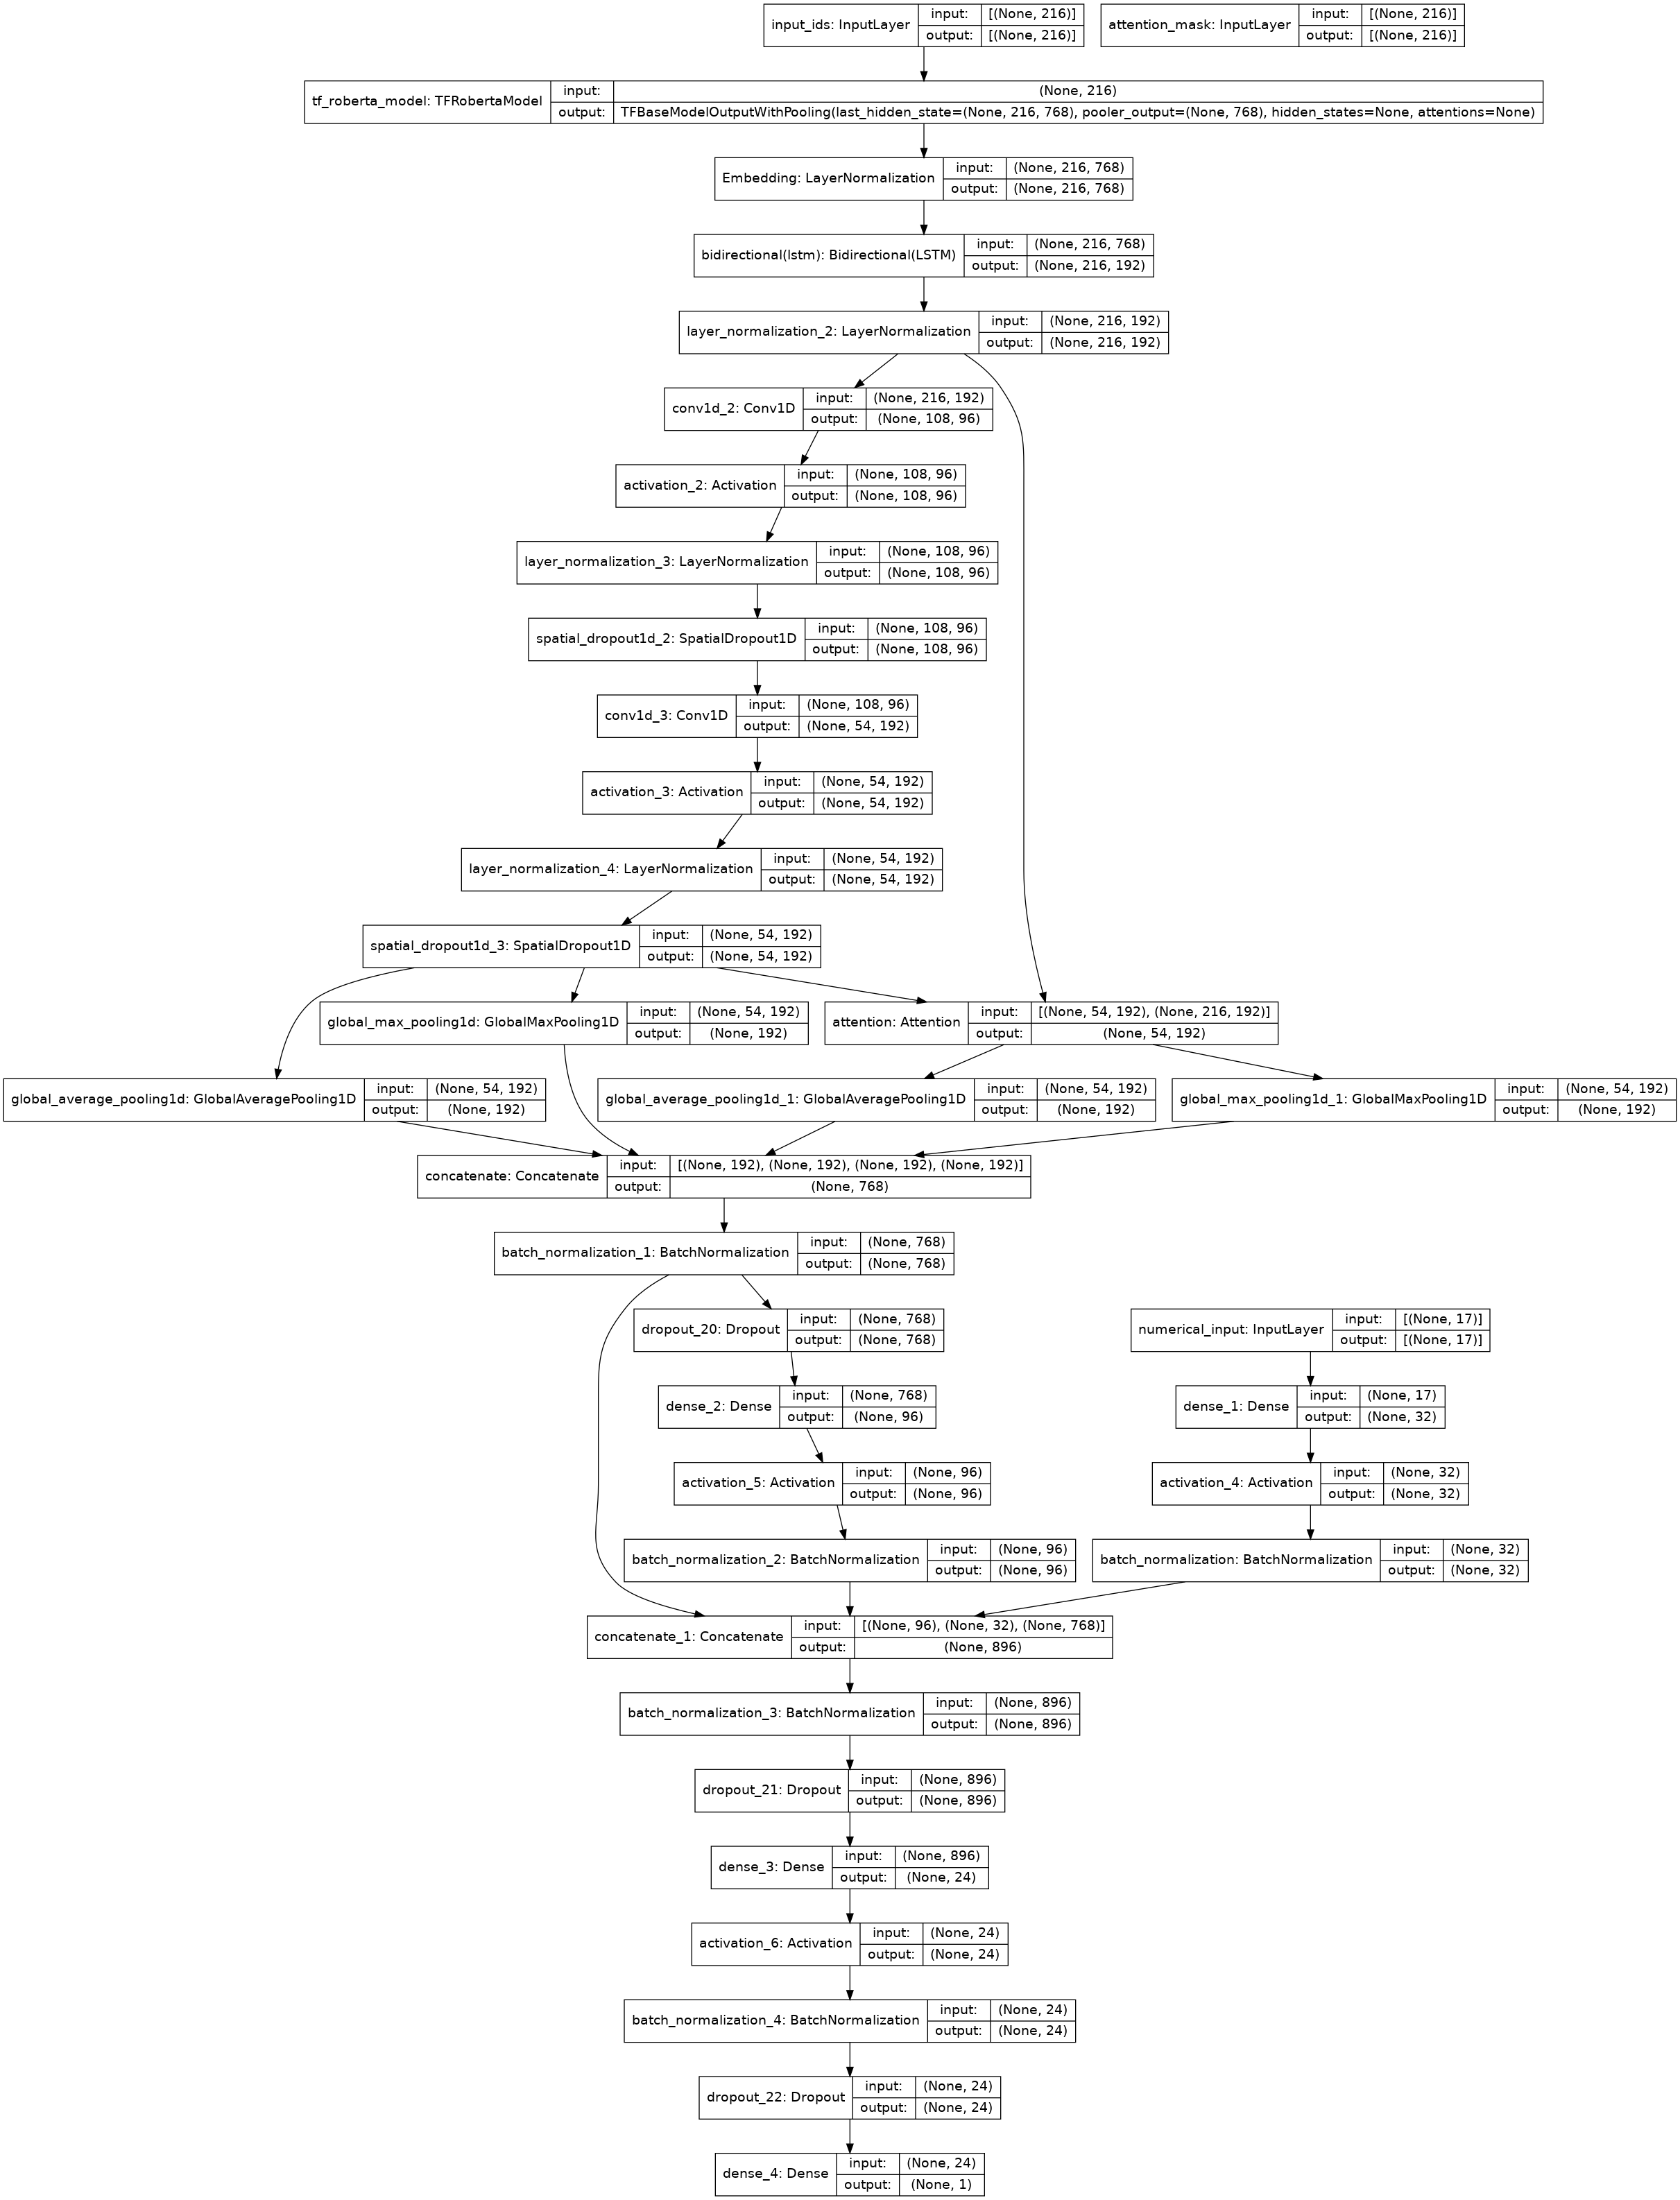

In [31]:
plot_model(
    model, to_file='./CommonLit_Readability_Model.png', 
    show_shapes=True, show_layer_names=True
)

In [32]:
FOLD = 5
VERBOSE = 1
MINI_BATCH_SIZE = 16
SEEDS = [2020]

counter = 0
oof_score1 = 0
oof_score2 = 0
y_pred_final = 0


for sidx, seed in enumerate(SEEDS):
    seed_score1 = 0
    seed_score2 = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(Xtrain, Ytrain_strat)):
        counter += 1

        train_x_id, train_x_mask = Xtrain_id[train], Xtrain_mask[train]
        val_x_id, val_x_mask = Xtrain_id[val], Xtrain_mask[val]
        train_x2, val_x2 = Xtrain.iloc[train], Xtrain.iloc[val]
        train_y, val_y = Ytrain[train], Ytrain[val]
        
        
        #==================================================================
        #                 Load pretrained DistilBert Model
        #==================================================================
        
        pretrained_model = distilroberta_model(transformer_model)
        pretrained_model.load_weights(f'../input/commonlit-roberta-variants-p1/DistilRoberta-Base/CLRP_DistilRoberta_Base_{(idx+1)}C.h5')
        pretrained_model.trainable = False
        
        
        #==================================================================
        #                              Model-1
        #==================================================================
        
        tf.random.set_seed(seed+idx+13)

        stat_input = Input(shape=(Xtrain.shape[1],), dtype=tf.int32, name="numerical_input")
        model1 = Model(inputs=[pretrained_model.input, stat_input], 
                       outputs=build_model(pretrained_model.get_layer('Embedding').output, stat_input, seed+idx+13),
                       name='CommonLit_Readability_Model')
        
        model1.compile(loss=rmse_loss,
                       metrics=[RootMeanSquaredError(name='rmse')],
                       optimizer=Adamax(lr=8e-3))

        early = EarlyStopping(monitor="val_rmse", mode="min", 
                              restore_best_weights=True, 
                              patience=9, verbose=VERBOSE)

        reduce_lr = ReduceLROnPlateau(monitor="val_rmse", factor=0.25, 
                                      min_lr=1e-6, patience=4, 
                                      verbose=VERBOSE, mode='min')

        chk_point = ModelCheckpoint(f'./CommonLit_Readability_Model1_{counter}C.h5', 
                                    monitor='val_rmse', verbose=VERBOSE, 
                                    save_best_only=True, mode='min',
                                    save_weights_only=True)
        
        history = model1.fit(
            [train_x_id, train_x_mask, train_x2], train_y, 
            batch_size=MINI_BATCH_SIZE,
            epochs=50, 
            verbose=VERBOSE, 
            workers=5,
            callbacks=[reduce_lr, early, chk_point], 
            validation_data=([val_x_id, val_x_mask, val_x2], val_y)
        )
        
        model1.load_weights(f'./CommonLit_Readability_Model1_{counter}C.h5')

        y_pred = model1.predict([val_x_id, val_x_mask, val_x2])
        score1 = np.sqrt(mean_squared_error(val_y, y_pred))
        oof_score1 += score1
        seed_score1 += score1
        print("Model-1 | Seed-{} | Fold-{} | OOF Score: {}".format(seed, idx, score1))
        
        
        #==================================================================
        #                              Model-2
        #==================================================================
        
        tf.random.set_seed(seed+idx+23)
        
        stat_input = Input(shape=(Xtrain.shape[1],), dtype=tf.int32, name="numerical_input")
        model2 = Model(inputs=[pretrained_model.input, stat_input], 
                       outputs=build_model(pretrained_model.get_layer('Embedding').output, stat_input, seed+idx+23),
                       name='CommonLit_Readability_Model')
        
        model2.compile(loss=rmse_loss,
                       metrics=[RootMeanSquaredError(name='rmse')],
                       optimizer=Adamax(lr=8e-3))

        early = EarlyStopping(monitor="val_rmse", mode="min", 
                              restore_best_weights=True, 
                              patience=9, verbose=VERBOSE)

        reduce_lr = ReduceLROnPlateau(monitor="val_rmse", factor=0.25, 
                                      min_lr=1e-6, patience=4, 
                                      verbose=VERBOSE, mode='min')

        chk_point = ModelCheckpoint(f'./CommonLit_Readability_Model2_{counter}C.h5', 
                                    monitor='val_rmse', verbose=VERBOSE, 
                                    save_best_only=True, mode='min',
                                    save_weights_only=True)
        
        history = model2.fit(
            [train_x_id, train_x_mask, train_x2], train_y, 
            batch_size=MINI_BATCH_SIZE,
            epochs=50, 
            verbose=VERBOSE, 
            workers=5,
            callbacks=[reduce_lr, early, chk_point], 
            validation_data=([val_x_id, val_x_mask, val_x2], val_y)
        )
        
        model2.load_weights(f'./CommonLit_Readability_Model2_{counter}C.h5')

        y_pred = model2.predict([val_x_id, val_x_mask, val_x2])
        score2 = np.sqrt(mean_squared_error(val_y, y_pred))
        oof_score2 += score2
        seed_score2 += score2
        print("Model-2 | Seed-{} | Fold-{} | OOF Score: {}".format(seed, idx, score2))
        
        if score1 > score2:
            y_pred_final += model2.predict([Xtest_id, Xtest_mask, Xtest])
            print("Predictions made using Model-2\n")
        
        elif score1 < score2:
            y_pred_final += model1.predict([Xtest_id, Xtest_mask, Xtest])
            print("Predictions made using Model-1\n")
        
        else:
            y_pred_final += model1.predict([Xtest_id, Xtest_mask, Xtest])
            print("Predictions made using Model-1\n")
    
    print("\nModel-1 | Seed: {} | Aggregate OOF Score: {}".format(seed, (seed_score1 / FOLD)))
    print("Model-2 | Seed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score2 / FOLD)))


y_pred_final = y_pred_final / float(counter)
oof_score1 /= float(counter)
oof_score2 /= float(counter)
oof_score = (oof_score1 + oof_score2) / 2.0
print("Model-1 OOF Score: {}".format(oof_score1))
print("Model-2 OOF Score: {}".format(oof_score2))
print("Aggregate OOF Score: {}".format(oof_score))

Epoch 1/50
142/142 [==============================] - 34s 148ms/step - loss: 1.1566 - rmse: 0.9331 - val_loss: 0.8809 - val_rmse: 0.6315

Epoch 00001: val_rmse improved from inf to 0.63152, saving model to ./CommonLit_Readability_Model1_1C.h5
Epoch 2/50
142/142 [==============================] - 19s 131ms/step - loss: 0.8575 - rmse: 0.6178 - val_loss: 0.8642 - val_rmse: 0.6431

Epoch 00002: val_rmse did not improve from 0.63152
Epoch 3/50
142/142 [==============================] - 18s 130ms/step - loss: 0.8281 - rmse: 0.6066 - val_loss: 0.8075 - val_rmse: 0.6024

Epoch 00003: val_rmse improved from 0.63152 to 0.60235, saving model to ./CommonLit_Readability_Model1_1C.h5
Epoch 4/50
142/142 [==============================] - 19s 132ms/step - loss: 0.8134 - rmse: 0.6154 - val_loss: 0.8107 - val_rmse: 0.6209

Epoch 00004: val_rmse did not improve from 0.60235
Epoch 5/50
142/142 [==============================] - 18s 130ms/step - loss: 0.7735 - rmse: 0.5900 - val_loss: 0.8911 - val_rmse: 0.

## Create submission file

In [33]:
submit_df = pd.read_csv("../input/commonlitreadabilityprize/sample_submission.csv")
submit_df['target'] = y_pred_final
submit_df.to_csv("./submission.csv", index=False)
submit_df.head()

,id,target
0,c0f722661,-0.801172
1,f0953f0a5,-0.764738
2,0df072751,-0.356479
3,04caf4e0c,-2.188669
4,0e63f8bea,-1.677674
